# Import initial libraries 

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import multilabel_confusion_matrix

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 

# Test MediaPipe Function with real camera 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('DATASET') 

# Actions that we try to detect
actions = np.array(['Beautiful', 'Clever', 'Cute', 'Dislike', 'Fine',
                    'Full', 'Good Luck', 'Hungry', 'Intelligent', 'Like',
                    'Love', 'Regret', 'Sad', 'Sick','Sorry',
                    'Thank You', "That's OK", 'Think of', 'Understand',])

# actions = np.array(['Like', 'Love', 'None'])
# Thirty videos worth of data
no_sequences = 90

# Videos are going to be 30 frames in length
sequence_length = 30

In [36]:
#for sequence in range(30, no_sequences + 30)
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [40]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 204, 102), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 204, 102), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Camera', image)
                    cv2.waitKey(1)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,204, 102), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Camera', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# Prepare Data for train and test

In [8]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [10]:
X_train.shape

(1026, 30, 1662)

# Train model

Train LSTM Model

In [12]:
model_LSTM = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)),
    Dropout(0.01),
    LSTM(128, return_sequences=True, activation='relu'),
    Dropout(0.01),
    LSTM(64, return_sequences=False, activation='relu'),
    Dropout(0.01),
    Dense(64, activation='relu'),
    Dropout(0.01),
    Dense(32, activation='relu'),
    Dense(actions.shape[0], activation='softmax')])

model_LSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=[
                   'categorical_accuracy'])
model_LSTM.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=120, batch_size=32)

Epoch 1/120
33/33 [==============================] - 9s 139ms/step - loss: 2.9440 - categorical_accuracy: 0.0497 - val_loss: 2.9164 - val_categorical_accuracy: 0.0614
Epoch 2/120
33/33 [==============================] - 4s 116ms/step - loss: 2.9127 - categorical_accuracy: 0.0487 - val_loss: 2.8604 - val_categorical_accuracy: 0.0614
Epoch 3/120
33/33 [==============================] - 3s 103ms/step - loss: 2.7481 - categorical_accuracy: 0.1131 - val_loss: 2.6687 - val_categorical_accuracy: 0.1023
Epoch 4/120
33/33 [==============================] - 4s 109ms/step - loss: 2.3348 - categorical_accuracy: 0.1959 - val_loss: 2.2109 - val_categorical_accuracy: 0.2091
Epoch 5/120
33/33 [==============================] - 3s 104ms/step - loss: 2.1491 - categorical_accuracy: 0.2388 - val_loss: 2.2505 - val_categorical_accuracy: 0.2836
Epoch 6/120
33/33 [==============================] - 3s 105ms/step - loss: 2.0241 - categorical_accuracy: 0.2661 - val_loss: 1.9550 - val_categorical_accuracy: 0.288

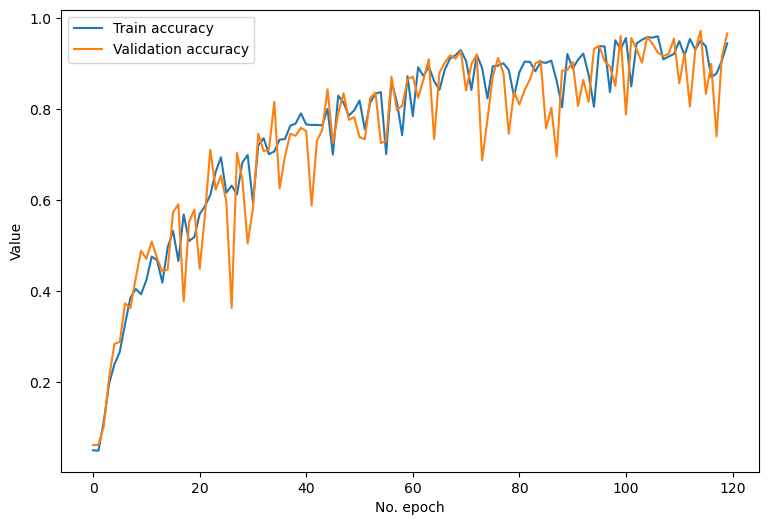

In [13]:
plt.figure(figsize=(9,6))
plt.plot(model_LSTM.history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(model_LSTM.history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()
# plt.savefig('Model/LSTM/plt_LSTM.png')

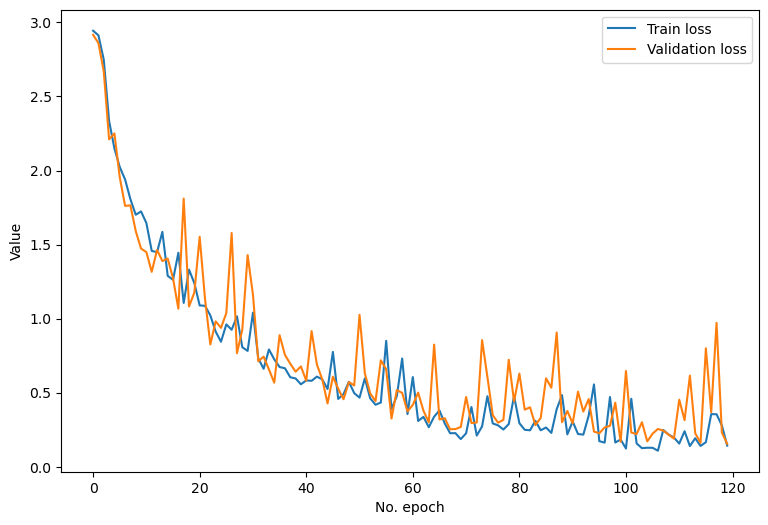

In [14]:
plt.figure(figsize=(9,6))
plt.plot(model_LSTM.history.history['loss'], label='Train loss')
plt.plot(model_LSTM.history.history['val_loss'], label='Validation loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [15]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 dropout_4 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [16]:
model_LSTM.save('Model/LSTM/LSTM_Model.h5')

In [17]:
model_LSTM = load_model('Model/LSTM/LSTM_Model.h5')

Test Accuracy Model

In [18]:
yhat = model_LSTM.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

model_LSTM.evaluate(X_train, y_train)
model_LSTM.evaluate(X_test, y_test)
# accuracy_score(ytrue, yhat)

22/22 [==============================] - 1s 30ms/step - loss: 0.1554 - categorical_accuracy: 0.9664


[0.15540391206741333, 0.9663742780685425]

In [19]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[647,   2],
        [  0,  35]],

       [[647,   2],
        [  1,  34]],

       [[649,   0],
        [  2,  33]],

       [[649,   5],
        [  1,  29]],

       [[647,   0],
        [  0,  37]],

       [[637,   2],
        [  0,  45]],

       [[646,   3],
        [  3,  32]],

       [[649,   0],
        [  1,  34]],

       [[644,   0],
        [  1,  39]],

       [[642,   0],
        [  6,  36]],

       [[655,   0],
        [  1,  28]],

       [[643,   1],
        [  0,  40]],

       [[653,   0],
        [  1,  30]],

       [[648,   2],
        [  0,  34]],

       [[646,   5],
        [  0,  33]],

       [[650,   0],
        [  2,  32]],

       [[645,   0],
        [  1,  38]],

       [[643,   1],
        [  1,  39]],

       [[649,   0],
        [  2,  33]]], dtype=int64)

# Test Model in real time

In [13]:
colors = (0, 204, 102)
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors, -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res, actions, image, colors))

In [87]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
confidence = 0.99

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FPS, 30)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model_LSTM.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

        # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] >= confidence:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1:
                sentence = sentence[-1:]

        cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('Result', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step
